# Cuisine Classifier

El objetivo es construir un modelo que permita determinar a partir de un conjutno de ingredientes a que país pertenece ese plato.

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error,f1_score, classification_report,confusion_matrix,ConfusionMatrixDisplay,precision_recall_curve,accuracy_score,precision_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



In [67]:
df = pd.read_csv("cuisines.csv")

df.head()

,Unnamed: 0,cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,...,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,65,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,indian,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,68,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,69,indian,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [68]:
print(df.shape)
print(df.info())

(2448, 385)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Columns: 385 entries, Unnamed: 0 to zucchini
dtypes: int64(384), object(1)
memory usage: 7.2+ MB
None


El dataset tiene 2448 observaciones. Disponemos de 385 atributos de los cuales, 384 son int y 1 es object

[Text(0.5, 1.0, 'Cantidad de cocinas por tipo')]

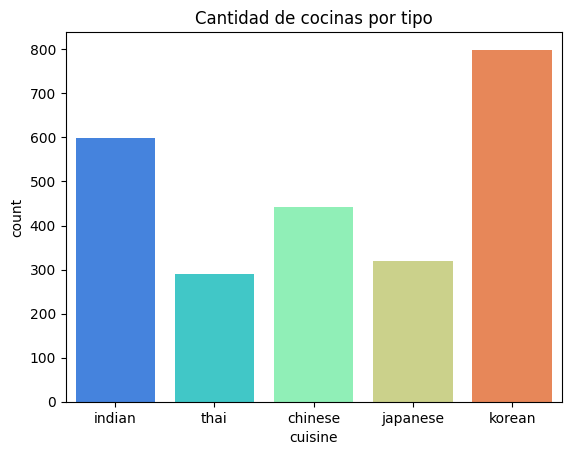

In [69]:
sns.countplot(data=df, x="cuisine",palette="rainbow" ).set(title="Cantidad de cocinas por tipo")


In [70]:
df.cuisine.value_counts()

korean      799
indian      598
chinese     442
japanese    320
thai        289
Name: cuisine, dtype: int64

En el gráfico se observa las cocinas que predominan son 'indian' y 'korean'. En menor proporción hay obervaciones de cocina 'thai','chinese' y 'japanese'. El dataset está desbalanceado

## Ingredientes dataframe
Crearemos un dataframe con los ingredientes típicos según el tipo de cocina

In [71]:
thai_df = df[(df.cuisine == "thai")]
korean_df = df[(df.cuisine == "korean")]
indian_df = df[(df.cuisine=="indian")]
chinese_df = df[(df.cuisine == "chinese")]
japanese_df = df[(df.cuisine == "japanese")]


In [72]:
def create_ingredient_df(df):
  """Está función transpone el DataFrame original, elimina las columnas 'cuisine' y 'Unnamed: 0',
  realiza la suma de los valores en cada fila y crea un nuevo DataFrame con una columna llamada 'value' que contiene los resultados de las sumas.
  """
  ing_df = df.T.drop(['cuisine','Unnamed: 0']).sum(axis=1).to_frame('value')
  ing_df = ing_df[(ing_df.T != 0).any()]
  ing_df = ing_df.sort_values(by='value', ascending=False, inplace=False)
  ing_df = ing_df.rename_axis('ingredient')

  return ing_df

<Axes: ylabel='ingredient'>

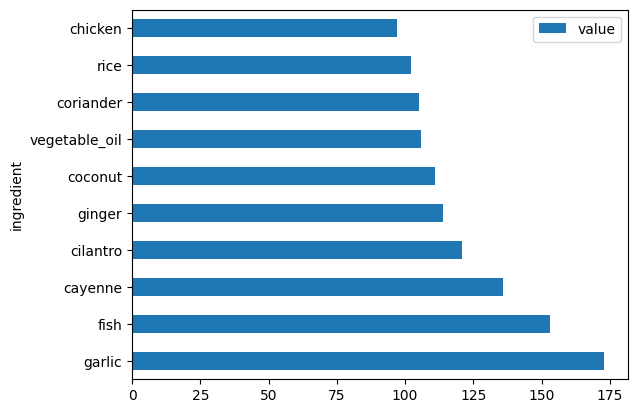

In [73]:
thai_ing_df = create_ingredient_df(thai_df)
thai_ing_df.head(10).plot.barh()

<Axes: ylabel='ingredient'>

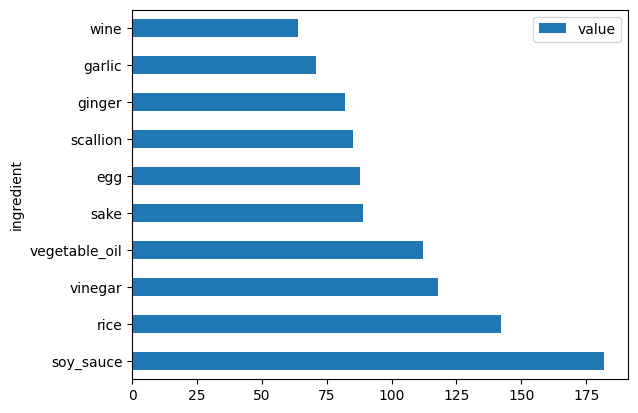

In [74]:
jpn_ing_df = create_ingredient_df(japanese_df)
jpn_ing_df.head(10).plot.barh()

<Axes: ylabel='ingredient'>

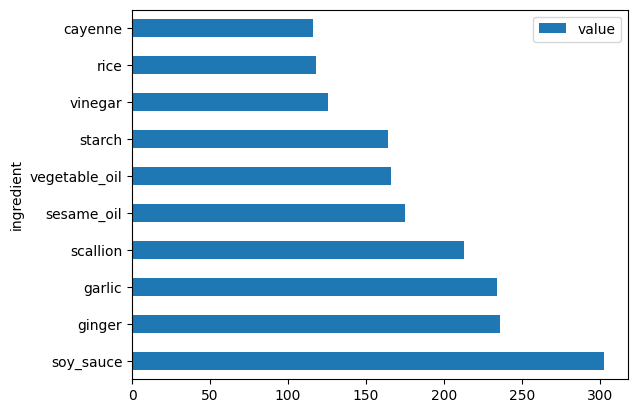

In [75]:
chinese_ing_df = create_ingredient_df(chinese_df)
chinese_ing_df.head(10).plot.barh()

<Axes: ylabel='ingredient'>

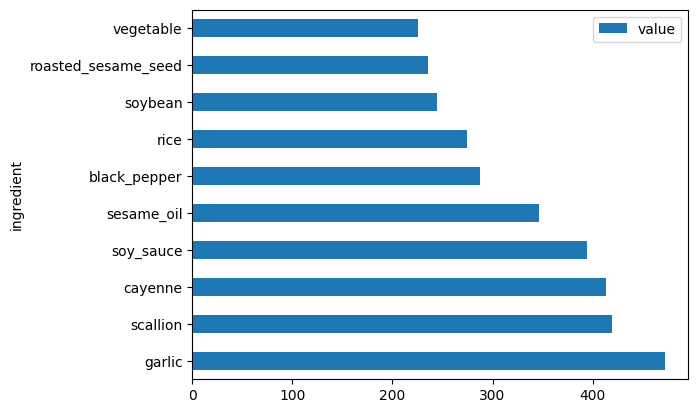

In [76]:
korean_ing_df = create_ingredient_df(korean_df)
korean_ing_df.head(10).plot.barh()

<Axes: ylabel='ingredient'>

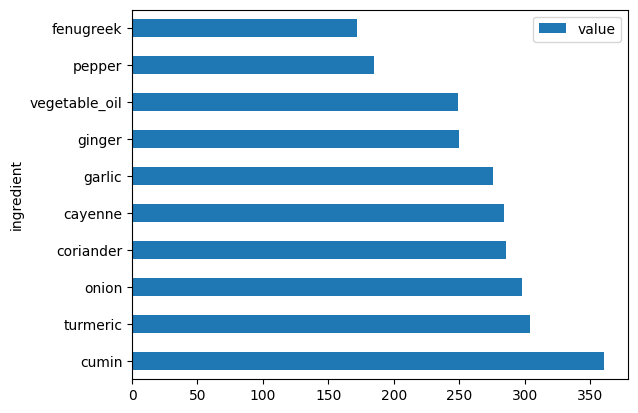

In [77]:
indian_ing_df = create_ingredient_df(indian_df)
indian_ing_df.head(10).plot.barh()

De los gráficos anteriores, podemos observar que los ingredientes mas comunes son 'rice','garlic' y 'ginger'. Los eliminaremos del dataset original.


In [78]:
df =  df.drop(['Unnamed: 0','rice','garlic','ginger'], axis=1)

## Balancear dataset

Para balancear utilizaremos el método SMOTE (Synthetic Minority Over-sampling Technique) de la librería ImbalancedLearn.

El proceso básico de SMOTE es el siguiente:



1.   Para cada muestra de la clase minoritaria, se selecciona aleatoriamente uno o varios de sus vecinos más cercanos.
2.   Se generan nuevas muestras sintéticas a lo largo de las líneas que conectan cada muestra con sus vecinos seleccionados. Estas nuevas muestras se encuentran dentro del espacio de características definido por los valores de las características existentes.
3. Las nuevas muestras sintéticas se agregan al conjunto de datos para equilibrar las clases.

El resultado final es un conjunto de datos donde la clase minoritaria está más representada, lo que puede mejorar el rendimiento de los algoritmos de aprendizaje automático al abordar el problema de desequilibrio de clases.

In [82]:
oversample = SMOTE()

feature_df= df.drop(['cuisine'], axis=1)
labels_df = df.cuisine


transformed_feature_df, transformed_label_df = oversample.fit_resample(feature_df, labels_df)

print(f'new label count: {transformed_label_df.value_counts()}')

print(f'old label count: {df.cuisine.value_counts()}')

transformed_df = pd.concat([transformed_label_df,transformed_feature_df],axis=1, join='outer')

new label count: indian      799
thai        799
chinese     799
japanese    799
korean      799
Name: cuisine, dtype: int64
old label count: korean      799
indian      598
chinese     442
japanese    320
thai        289
Name: cuisine, dtype: int64


In [ ]:
transformed_df.to_csv("../data/cleaned_cuisines.csv")


## Predecir cocina

Construiremos distintos modelos para predecir una cocina a partir de los ingredientes

In [87]:
X_train, X_test, y_train, y_test = train_test_split(feature_df, labels_df, test_size=0.3)

### Logistic Regression

In [90]:
lr = LogisticRegression(multi_class="ovr",solver="liblinear")

model = lr.fit(X_train,np.ravel(y_train))

accuracy = model.score(X_test, y_test)
print ("Accuracy is {}".format(accuracy))

Accuracy is 0.7836734693877551


### Otros clasificadores

Usaremos para clasificar:


1.   Linear SVC
2.   KNN
3. Support Vector Classifier
4. Ensemble Classifiers:
      * Random Forest
      * AdaBoost




*C* representa el parámetro de penalización del clasificador. Este controla el equilibrio entre lograr una separación óptima de las clases y permitir que algunas muestras se clasifiquen incorrectamente. Un valor más bajo de C permite más errores de clasificación, mientras que un valor más alto busca minimizar los errores.

In [99]:
C = 10
# Create different classifiers.
classifiers = {
     'Linear SVC': SVC(kernel='linear', C=C, probability=True,random_state=0),
      'KNN classifier': KNeighborsClassifier(C),
     'SVC': SVC(),
     'RFST': RandomForestClassifier(n_estimators=100),
    'ADA': AdaBoostClassifier(n_estimators=100)
    }

n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, np.ravel(y_train))

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))
    print(classification_report(y_test,y_pred))

Accuracy (train) for Linear SVC: 73.7% 
              precision    recall  f1-score   support

     chinese       0.50      0.63      0.56       122
      indian       0.88      0.85      0.86       179
    japanese       0.60      0.56      0.58        98
      korean       0.83      0.80      0.81       252
        thai       0.76      0.68      0.72        84

    accuracy                           0.74       735
   macro avg       0.71      0.70      0.71       735
weighted avg       0.75      0.74      0.74       735

Accuracy (train) for KNN classifier: 69.0% 
              precision    recall  f1-score   support

     chinese       0.49      0.54      0.51       122
      indian       0.78      0.84      0.81       179
    japanese       0.66      0.55      0.60        98
      korean       0.71      0.83      0.76       252
        thai       0.93      0.33      0.49        84

    accuracy                           0.69       735
   macro avg       0.71      0.62      0.64    

El modelo que tiene mejor desempeño es el de SVC con un accuracy del 79%.